In [1]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import DBFunctions as db
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
#cnx = sqlite3.connect('Prognosedaten.db')

#df = db.GetLoad().join(db.GetRenewables()).join(db.GetLoad()).join(db.GetIDPrices())
df = db.GetNRVSaldo().join(db.GetLoad()).join(db.GetIDPrices()).join(db.GetDAPrices()).join(db.GetRenewables()).join(db.GetSRL())


num_folds = 4

acc_per_fold = []
loss_per_fold = []

ValueError: could not convert string to float: '-268.678*'

In [3]:
df["PV_Error"] = df["PV_Ante"] - df["PV_Post"]
df["WI_Error"] = df["WI_Ante"] - df["WI_Post"]
df=df.drop(['PV_Ante','PV_Post','WI_Ante','WI_Post'], axis=1)
df=df.drop(['VorgehMenge_Neg','VorgehMenge_Pos','Leistungspreis_Pos','Leistungspreis_Neg'], axis=1)
df=df.rename(columns={"Arbeitspreis_Pos": "SRL_Arbeitspreis_Pos", "Arbeitspreis_Neg": "SRL_Arbeitspreis_Neg", "AbgerMenge_Pos": "SRL_AbgerMenge_Pos", "AbgerMenge_Neg": "SRL_AbgerMenge_Neg"})
df = df.dropna()

In [4]:


print(df.shape)
#print(df.dropna())

(130923, 12)


In [5]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

pdY_train = train[['SRL_AbgerMenge_Pos', 'SRL_AbgerMenge_Neg', 'SRL_Arbeitspreis_Pos','SRL_Arbeitspreis_Neg']].copy()
pdX_train = train.drop(['SRL_AbgerMenge_Pos', 'SRL_AbgerMenge_Neg', 'SRL_Arbeitspreis_Pos','SRL_Arbeitspreis_Neg'], axis=1)

pdY_test = test[['SRL_AbgerMenge_Pos', 'SRL_AbgerMenge_Neg', 'SRL_Arbeitspreis_Pos','SRL_Arbeitspreis_Neg']].copy()
pdX_test = test.drop(['SRL_AbgerMenge_Pos', 'SRL_AbgerMenge_Neg', 'SRL_Arbeitspreis_Pos','SRL_Arbeitspreis_Neg'], axis=1)

#pdX_train=(pdX_train-pdX_train.min())/(pdX_train.max()-pdX_train.min())
#pdX_test=(pdX_test-pdX_test.min())/(pdX_test.max()-pdX_test.min())

Xtrain = pdX_train.to_numpy()
Ytrain = pdY_train.to_numpy()

Xtest  = pdX_test.to_numpy()
Ytest  = pdY_test.to_numpy()

Xtrain = np.asarray(Xtrain).astype(np.float32)
Ytrain = np.asarray(Ytrain).astype(np.float32)
Xtest = np.asarray(Xtest).astype(np.float32)
Ytest = np.asarray(Ytest).astype(np.float32)
#print(train.shape)
#print(pdX_test.columns)
#print(pdX_test)
#print("Data poccessed starting on the ML stuff")
#print(Xtest[:, [2]])
#plt.plot(Xtest[:, [2]],color='blue',linewidth=0.1)
#plt.show()
print(Xtest)
print(Xtest[:,0])


[[ 4.603800e+02  4.834500e+04  4.805000e+01 ...  7.153450e+03
   0.000000e+00 -4.913100e+02]
 [ 5.028270e+02  4.789200e+04  2.890000e+01 ...  7.153450e+03
   0.000000e+00 -5.705000e+02]
 [-1.457050e+02  4.450300e+04  1.239000e+01 ...  7.571775e+03
   0.000000e+00 -6.103400e+02]
 ...
 [-1.191147e+03  5.752700e+04  3.093000e+01 ...  1.819120e+04
   0.000000e+00 -5.711762e+03]
 [-4.056060e+02  5.399700e+04  2.770000e+01 ...  1.873710e+04
   0.000000e+00 -6.025624e+03]
 [-5.295570e+02  5.269900e+04  2.413000e+01 ...  1.873710e+04
   0.000000e+00 -5.871179e+03]]
[  460.38    502.827  -145.705 ... -1191.147  -405.606  -529.557]


In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [7]:
def get_model():

	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(90, activation='relu', input_shape=[Xtrain.shape[1]]))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(tf.keras.layers.Dense(4))
	
	sgd = tf.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
	rmspop = tf.keras.optimizers.RMSprop(0.001)#chills at 2.3
	model.compile(optimizer=rmspop,loss='mean_squared_error')
	return model

In [8]:
model = get_model()
_ = model.fit(Xtrain,Ytrain,
	#batch_size=64,
	epochs=20,
	#steps_per_epoch=5,
	#verbose=1,
	validation_data = (Xtest,Ytest))
	#callbacks=[callback])
#print(pdX_train)

Epoch 1/20
3274/3274 [==============================] - 10s 3ms/step - loss: 2894.3201 - val_loss: 740.3672
Epoch 2/20
3274/3274 [==============================] - 9s 3ms/step - loss: 805.9260 - val_loss: 1129.7657
Epoch 3/20
3274/3274 [==============================] - 10s 3ms/step - loss: 784.2685 - val_loss: 668.4613
Epoch 4/20
3274/3274 [==============================] - 9s 3ms/step - loss: 771.9939 - val_loss: 1022.6089
Epoch 5/20
3274/3274 [==============================] - 9s 3ms/step - loss: 764.5399 - val_loss: 792.5014
Epoch 6/20
3274/3274 [==============================] - 10s 3ms/step - loss: 759.9250 - val_loss: 669.8866
Epoch 7/20
3274/3274 [==============================] - 9s 3ms/step - loss: 754.7709 - val_loss: 728.3295
Epoch 8/20
3274/3274 [==============================] - 10s 3ms/step - loss: 752.0267 - val_loss: 794.8193
Epoch 9/20
3274/3274 [==============================] - 10s 3ms/step - loss: 747.4963 - val_loss: 780.6823
Epoch 10/20
3274/3274 [===============

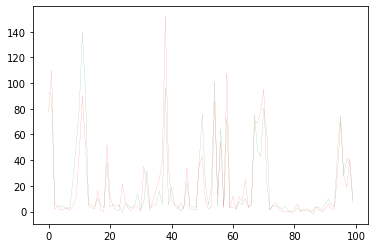

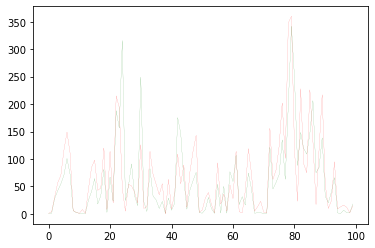

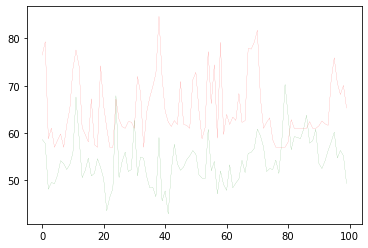

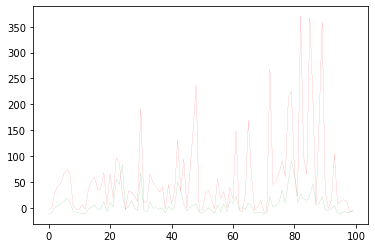

In [9]:
predictions = model.predict(Xtest)

#truth = Y_MRL_Arbeitspreis_Pos >= predictions
#for i in range(truth.shape[0]):
#    if (truth[0][i]):
#        predictions[i] = Y_MRL_Arbeitspreis_Pos[i]
for i in range(4):
    plt.plot(predictions[:100,i],color='green',linewidth=0.1)
    plt.plot(Ytest[:100,i],color='red',linewidth=0.1)
    plt.show()





In [10]:
data = np.array([[1, 2], [3,4], [5,6], [7,8]])
print(data)


# Creating pandas dataframe from numpy array
dataset = pd.DataFrame({'Column1': data[:, 0],'Column2': data[:, 1]})
print(dataset)
dataset.Column1 *=5.44
print(dataset)

#print(dataset.sample(frac=0.8,random_state=200))

#normed_matrix = normalize(et, axis=0, norm='l1')

#df.sample(frac=0.8,random_state=200)


[[1 2]
 [3 4]
 [5 6]
 [7 8]]
   Column1  Column2
0        1        2
1        3        4
2        5        6
3        7        8
   Column1  Column2
0     5.44        2
1    16.32        4
2    27.20        6
3    38.08        8


In [11]:
df1 = pd.DataFrame(np.random.randint(0,5,size=(4, 4)), columns=list('ABCD'))
df2 = pd.DataFrame(np.random.randint(0,5,size=(4, 4)), columns=list('ABCD'))

for i in range(0,4):
    df1['A'][i] = i;
    df2['A'][i] = i;


print(df1)
print(df2)


df1.reset_index('A', drop=False).join(df2.rename_axis('a1').set_index('a2', append=True)

print(df1)

SyntaxError: invalid syntax (<ipython-input-11-c4735f7a05cd>, line 15)